# 01 - Exploración y Preprocesamiento de Radiografías de Tórax

## Introducción

En este notebook abordamos la **Parte 1** del proyecto de clasificación de imágenes médicas: la exploración inicial y el preprocesamiento de radiografías de tórax para el diagnóstico de neumonía.

Las radiografías presentan desafíos particulares: variabilidad en calidad, diferencias de exposición, artefactos, y desbalance de clases. Un preprocesamiento cuidadoso es crítico para:

- Estandarizar representaciones (tamaño, rango de intensidades)
- Mejorar contraste local (estructuras pulmonares sutiles)
- Reducir ruido irrelevante
- Enfocar la región anatómica útil

Este flujo sienta las bases para la extracción de características y el modelado posterior.

## Objetivos de Este Notebook

1. Cargar el dataset (estructura esperada)
2. Explorar ejemplos de cada clase (NORMAL vs PNEUMONIA)
3. Analizar distribución de clases
4. Revisar tamaños y proporciones de imagen
5. Implementar y justificar el pipeline de preprocesamiento:
   - Normalización de tamaño (224x224)
   - Normalización de intensidades
   - Mejora de contraste (CLAHE)
   - Segmentación de la región pulmonar
6. Visualizar comparaciones antes/después
7. Registrar conclusiones parciales

## Justificación de Técnicas

### ¿Por qué normalizar el tamaño?

Las redes y descriptores clásicos requieren una dimensión consistente para construir vectores comparables y aprovechar pesos pre-entrenados (e.g. 224x224 en CNN estándar). Además, simplifica batch processing y reduce variabilidad artificial.

### ¿Por qué CLAHE?

Las radiografías pueden tener áreas subexpuestas o sobreexpuestas. El **CLAHE (Contrast Limited Adaptive Histogram Equalization)** mejora el contraste local adaptativamente sin exagerar el ruido y preserva estructuras finas relevantes (infiltrados, opacidades). Limitar el clip evita saturación en regiones homogéneas.

### ¿Por qué preprocesar radiografías?

- Reduce artefactos y variaciones de adquisición
- Aumenta la señal discriminativa (patrones pulmonares)
- Minimiza el sesgo por diferencias de escala/iluminación
- Mejora la estabilidad y convergencia de modelos posteriores

In [1]:
# Importaciones principales y configuración
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter

# Ajustes de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Reproducibilidad
np.random.seed(42)

# Añadir src al path para importaciones relativas
project_root = Path('..').resolve()
src_path = project_root / 'src'
sys.path.append(str(src_path))

print(f"Ruta del proyecto detectada: {project_root}")

Ruta del proyecto detectada: C:\Users\David.Londono\Documents\Vision\TRABAJO-03


In [2]:
# Importar módulos personalizados
from utils import (
    list_images, 
    load_image, 
    plot_image_grid, 
    plot_class_distribution, 
    analyze_dataset_sizes, 
    plot_image_comparison, 
    plot_histogram, 
    plot_multiple_histograms
)

from preprocessing import (
    apply_clahe, 
    preprocess_xray, 
    segment_lung_region, 
    resize_image, 
    apply_histogram_equalization, 
    compare_preprocessing_methods,
    preprocess_dataset
)

print("✓ Módulos personalizados importados correctamente")

✓ Módulos personalizados importados correctamente


## Estructura Esperada del Dataset

Se asume que el dataset de Kaggle fue descargado y descomprimido en `data/raw/`. Estructura típica del dataset original:

```
data/raw/chest_xray/
├── train/
│   ├── NORMAL/
│   └── PNEUMONIA/
├── val/
│   ├── NORMAL/
│   └── PNEUMONIA/
└── test/
    ├── NORMAL/
    └── PNEUMONIA/
```

Para esta exploración inicial nos concentramos en la carpeta `train/`.

In [3]:
# Definición de rutas
DATA_ROOT = Path('../data/raw/chest_xray')
TRAIN_DIR = DATA_ROOT / 'train'
NORMAL_DIR = TRAIN_DIR / 'NORMAL'
PNEUMONIA_DIR = TRAIN_DIR / 'PNEUMONIA'

print("Directorio base dataset:", DATA_ROOT)
print("¿Existe dataset?", DATA_ROOT.exists())
print("¿Existe directorio train?", TRAIN_DIR.exists())

Directorio base dataset: ..\data\raw\chest_xray
¿Existe dataset? True
¿Existe directorio train? True


In [4]:
# Verificar disponibilidad de imágenes y listar algunas
if not TRAIN_DIR.exists():
    print("⚠️ El directorio de entrenamiento no existe.")
    print("   Asegúrate de haber colocado el dataset en data/raw/chest_xray.")
    print("   Descarga desde: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")
    sample_normal_paths = []
    sample_pneumonia_paths = []
else:
    sample_normal_paths = list_images(str(NORMAL_DIR))[:8]
    sample_pneumonia_paths = list_images(str(PNEUMONIA_DIR))[:8]
    print(f"✓ Ejemplos NORMAL encontrados: {len(sample_normal_paths)}")
    print(f"✓ Ejemplos PNEUMONIA encontrados: {len(sample_pneumonia_paths)}")

✓ Ejemplos NORMAL encontrados: 8
✓ Ejemplos PNEUMONIA encontrados: 8


In [5]:
# Cargar imágenes ejemplo para visualización
sample_normal_imgs = [load_image(p) for p in sample_normal_paths]
sample_pneumonia_imgs = [load_image(p) for p in sample_pneumonia_paths]

# Filtrar posibles None
sample_normal_imgs = [img for img in sample_normal_imgs if img is not None]
sample_pneumonia_imgs = [img for img in sample_pneumonia_imgs if img is not None]

print(f"Imágenes NORMAL cargadas: {len(sample_normal_imgs)}")
print(f"Imágenes PNEUMONIA cargadas: {len(sample_pneumonia_imgs)}")

Imágenes NORMAL cargadas: 8
Imágenes PNEUMONIA cargadas: 8


## Visualización Inicial de Ejemplos por Clase

Se muestran mosaicos de ejemplos representativos de cada clase para apreciar diferencias visuales: patrones de opacidad, infiltrados, contraste general.


=== RADIOGRAFÍAS NORMALES ===


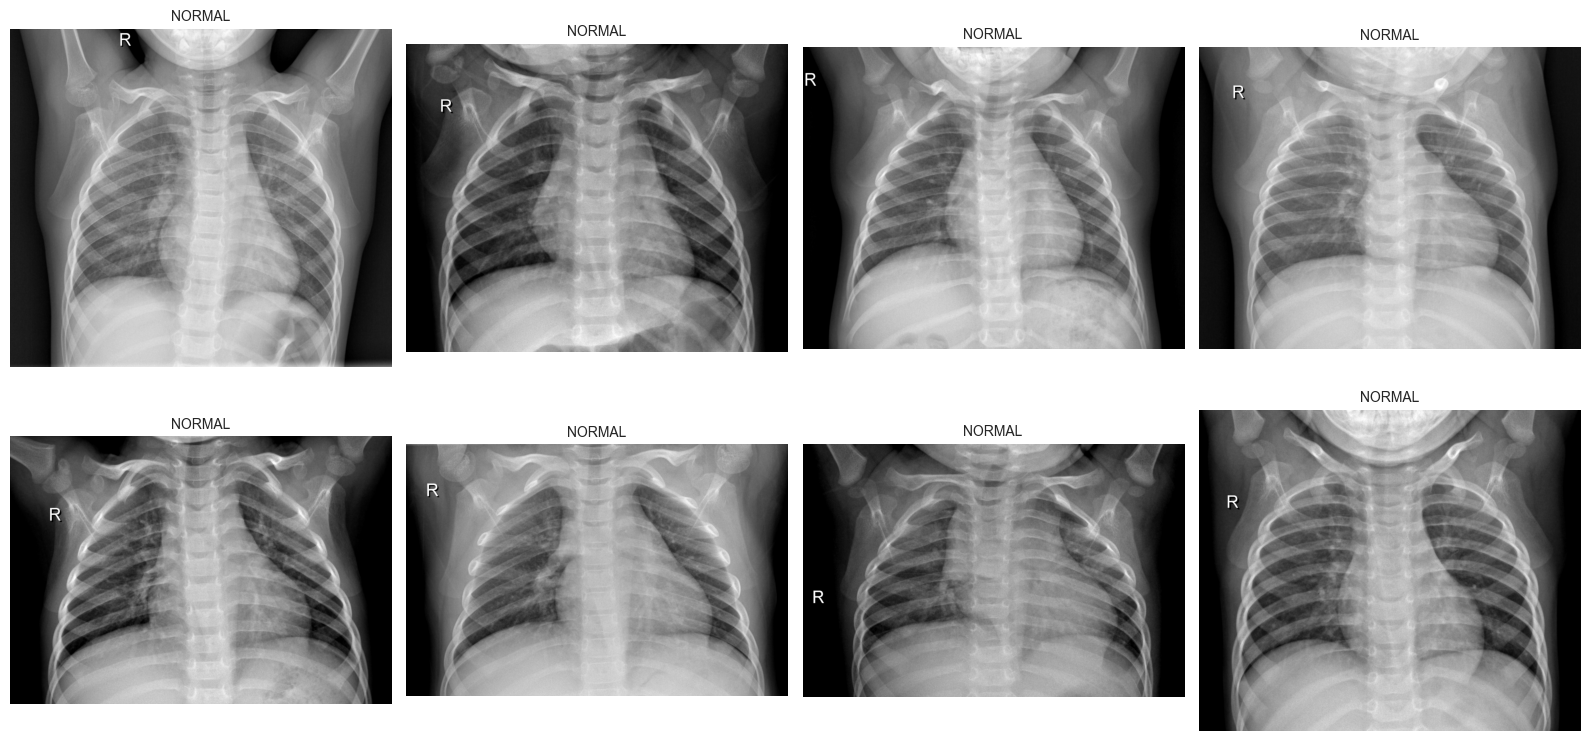

In [6]:
# Mostrar mosaico de imágenes NORMALES
if sample_normal_imgs:
    print("\n=== RADIOGRAFÍAS NORMALES ===")
    plot_image_grid(sample_normal_imgs, 
                   titles=["NORMAL"]*len(sample_normal_imgs), 
                   rows=2, cols=4, figsize=(16, 8))
else:
    print("Sin imágenes NORMAL para mostrar.")


=== RADIOGRAFÍAS CON NEUMONÍA ===


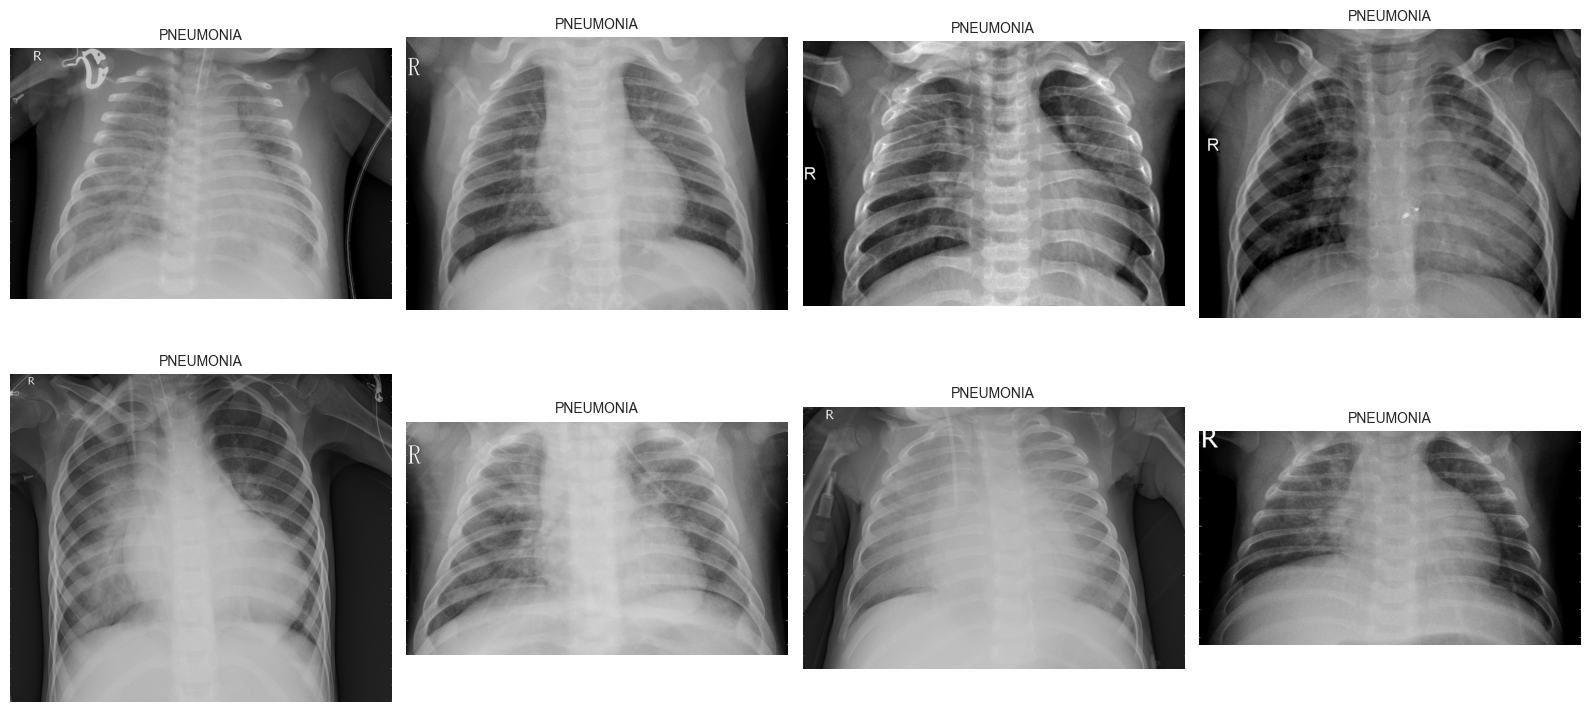

In [7]:
# Mostrar mosaico de imágenes con NEUMONÍA
if sample_pneumonia_imgs:
    print("\n=== RADIOGRAFÍAS CON NEUMONÍA ===")
    plot_image_grid(sample_pneumonia_imgs, 
                   titles=["PNEUMONIA"]*len(sample_pneumonia_imgs), 
                   rows=2, cols=4, figsize=(16, 8))
else:
    print("Sin imágenes PNEUMONIA para mostrar.")

## Distribución de Clases

La distribución de clases influye directamente en el sesgo del modelo y métricas como Accuracy. Es importante inspeccionar si hay desbalance y planear estrategias (reweighting, data augmentation, métricas robustas).


=== DISTRIBUCIÓN DE CLASES ===
NORMAL: 1341 imágenes
PNEUMONIA: 3875 imágenes

Ratio PNEUMONIA/NORMAL: 2.89


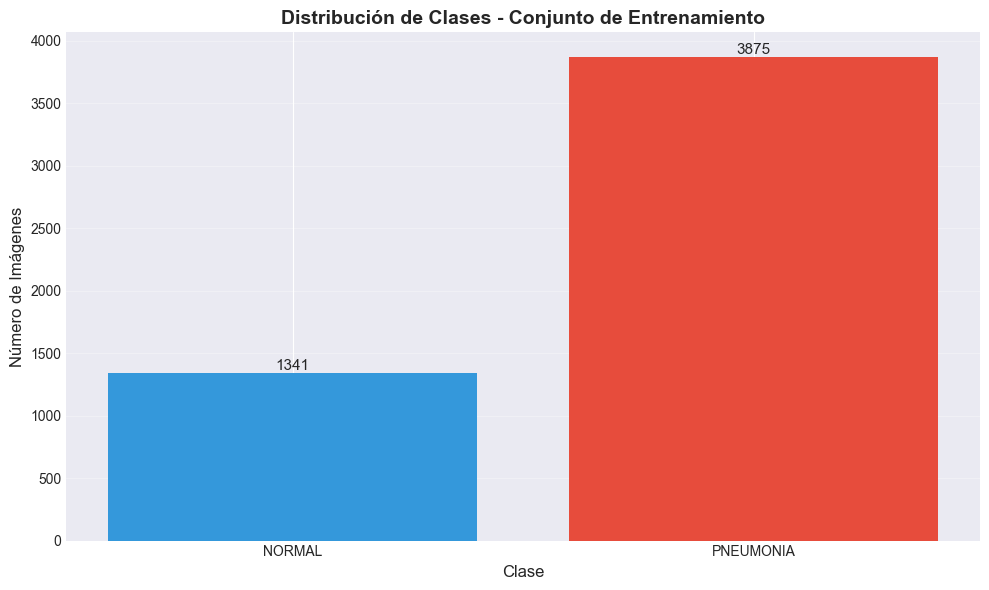

In [8]:
# Conteo de clases en train
class_counts = {}
if TRAIN_DIR.exists():
    class_counts['NORMAL'] = len(list_images(str(NORMAL_DIR)))
    class_counts['PNEUMONIA'] = len(list_images(str(PNEUMONIA_DIR)))
    
    print("\n=== DISTRIBUCIÓN DE CLASES ===")
    for clase, count in class_counts.items():
        print(f"{clase}: {count} imágenes")
    
    # Calcular ratio
    if class_counts['NORMAL'] > 0:
        ratio = class_counts['PNEUMONIA'] / class_counts['NORMAL']
        print(f"\nRatio PNEUMONIA/NORMAL: {ratio:.2f}")
    
    # Visualizar
    plot_class_distribution(class_counts, title="Distribución de Clases - Conjunto de Entrenamiento")
else:
    print("Dataset no disponible para conteo de clases.")

## Análisis de Tamaños de Imagen

Las imágenes pueden tener resoluciones variadas. Analizamos su distribución para justificar la normalización a un tamaño estándar.

In [9]:
if TRAIN_DIR.exists():
    print("\n=== ANÁLISIS DE TAMAÑOS DE IMAGEN ===")
    sizes_df = analyze_dataset_sizes(str(TRAIN_DIR))
    
    print("\nPrimeras filas del análisis:")
    print(sizes_df.head(10))
    
    print("\nEstadísticas descriptivas:")
    print(sizes_df.describe())
else:
    print("No se puede analizar tamaños sin dataset.")


=== ANÁLISIS DE TAMAÑOS DE IMAGEN ===

Primeras filas del análisis:
    clase  ancho  alto   aspecto
0  NORMAL   2090  1858  1.124865
1  NORMAL   1422  1152  1.234375
2  NORMAL   1810  1434  1.262204
3  NORMAL   1618  1279  1.265051
4  NORMAL   1600  1125  1.422222
5  NORMAL   1974  1306  1.511485
6  NORMAL   1528  1013  1.508391
7  NORMAL   1384  1167  1.185947
8  NORMAL   1450  1144  1.267483
9  NORMAL   1468   993  1.478348

Estadísticas descriptivas:
             ancho         alto      aspecto
count  5216.000000  5216.000000  5216.000000
mean   1320.610813   968.074770     1.440236
std     355.298743   378.855691     0.257309
min     384.000000   127.000000     0.835391
25%    1056.000000   688.000000     1.257470
50%    1284.000000   888.000000     1.411701
75%    1552.000000  1187.750000     1.583418
max    2916.000000  2663.000000     3.378788


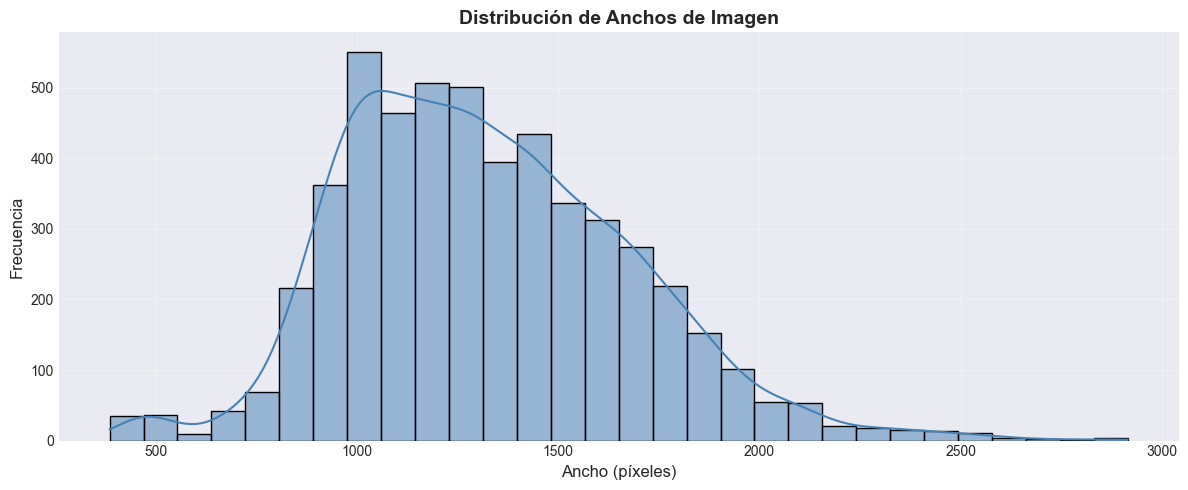

In [10]:
# Visualizar distribución de anchos
if TRAIN_DIR.exists():
    plt.figure(figsize=(12, 5))
    sns.histplot(sizes_df['ancho'], kde=True, color='steelblue', bins=30)
    plt.title('Distribución de Anchos de Imagen', fontsize=14, fontweight='bold')
    plt.xlabel('Ancho (píxeles)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

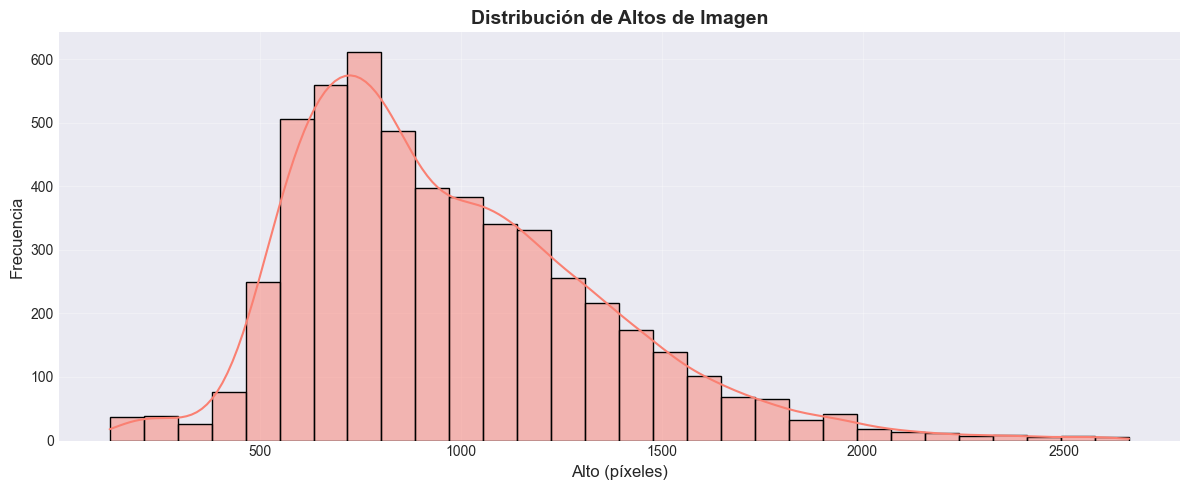

In [11]:
# Visualizar distribución de altos
if TRAIN_DIR.exists():
    plt.figure(figsize=(12, 5))
    sns.histplot(sizes_df['alto'], kde=True, color='salmon', bins=30)
    plt.title('Distribución de Altos de Imagen', fontsize=14, fontweight='bold')
    plt.xlabel('Alto (píxeles)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

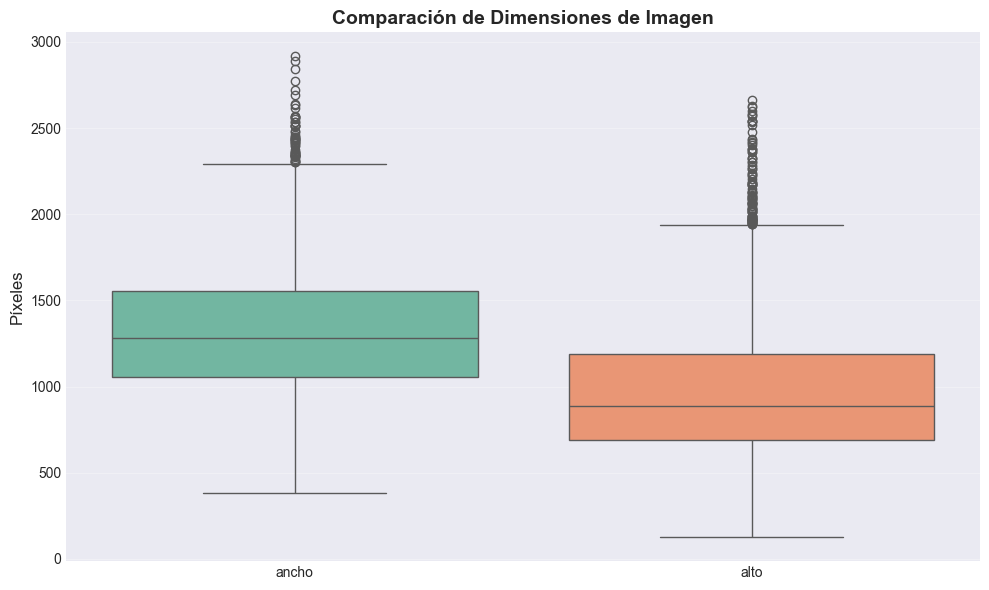

In [12]:
# Boxplot comparativo
if TRAIN_DIR.exists():
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=sizes_df[['ancho', 'alto']], palette='Set2')
    plt.title('Comparación de Dimensiones de Imagen', fontsize=14, fontweight='bold')
    plt.ylabel('Píxeles', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

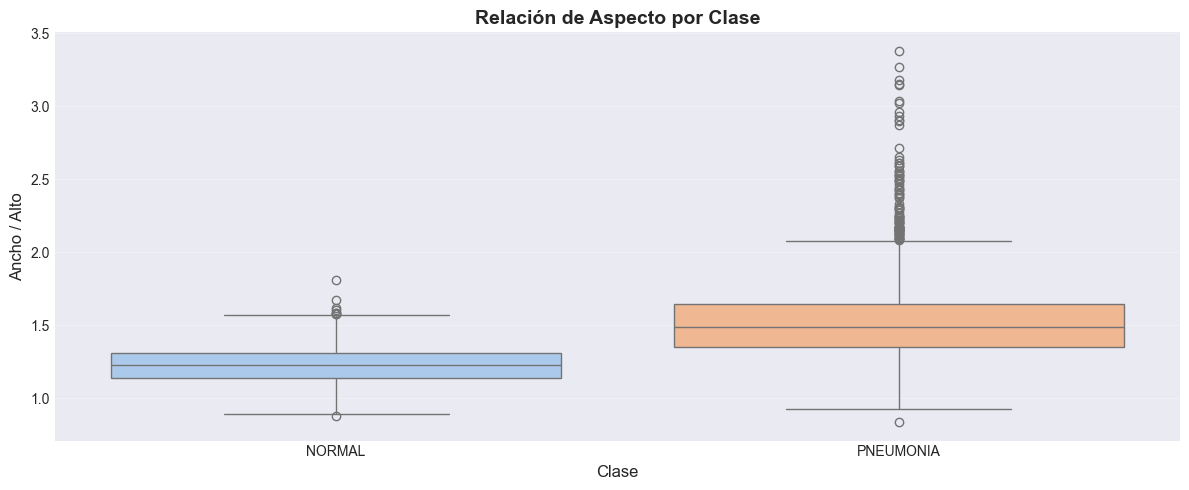

In [13]:
# Análisis de aspect ratio por clase
if TRAIN_DIR.exists():
    plt.figure(figsize=(12, 5))
    sns.boxplot(data=sizes_df, x='clase', y='aspecto', palette='pastel')
    plt.title('Relación de Aspecto por Clase', fontsize=14, fontweight='bold')
    plt.ylabel('Ancho / Alto', fontsize=12)
    plt.xlabel('Clase', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Selección de Ejemplos para Preprocesamiento

Elegimos una imagen de cada clase para ilustrar los pasos del pipeline (original, CLAHE, segmentación opcional, normalización de tamaño).

In [14]:
# Seleccionar una imagen de cada clase para demostración
example_normal = sample_normal_imgs[0] if sample_normal_imgs else None
example_pneumonia = sample_pneumonia_imgs[0] if sample_pneumonia_imgs else None

print("Imagen ejemplo NORMAL disponible?", example_normal is not None)
print("Imagen ejemplo PNEUMONIA disponible?", example_pneumonia is not None)

if example_normal is not None:
    print(f"Dimensiones NORMAL: {example_normal.shape}")
if example_pneumonia is not None:
    print(f"Dimensiones PNEUMONIA: {example_pneumonia.shape}")

Imagen ejemplo NORMAL disponible? True
Imagen ejemplo PNEUMONIA disponible? True
Dimensiones NORMAL: (1858, 2090)
Dimensiones PNEUMONIA: (760, 1152)


## Pipeline de Preprocesamiento

Pasos del pipeline:
1. Reducción de ruido
2. Normalización de intensidades (min-max)
3. Mejora de contraste (CLAHE)
4. Segmentación de región pulmonar y recorte
5. Redimensionamiento a 224x224

In [15]:
# Función auxiliar para demostrar pipeline
def demonstrate_pipeline(image, label):
    """Demuestra el pipeline de preprocesamiento en una imagen."""
    if image is None:
        print(f"No hay imagen para {label}")
        return
    
    print(f"\n{'='*60}")
    print(f"DEMOSTRANDO PIPELINE: {label}")
    print(f"{'='*60}")
    
    # Pipeline sin segmentación
    processed_basic = preprocess_xray(image, segment_roi=False)
    
    # Pipeline con segmentación
    processed_segmented = preprocess_xray(image, segment_roi=True)
    
    # Comparaciones visuales
    plot_image_comparison(image, processed_basic, 
                         title1=f"Original {label}", 
                         title2=f"Preprocesada {label}")
    
    plot_image_comparison(processed_basic, processed_segmented, 
                         title1=f"Sin Segmentación {label}", 
                         title2=f"Con ROI Segmentada {label}")
    
    # Histogramas antes y después
    plot_multiple_histograms([image, processed_basic], 
                            ["Original", "Preprocesada"], 
                            title=f"Histogramas {label}")

print("Función de demostración definida.")

Función de demostración definida.



DEMOSTRANDO PIPELINE: NORMAL


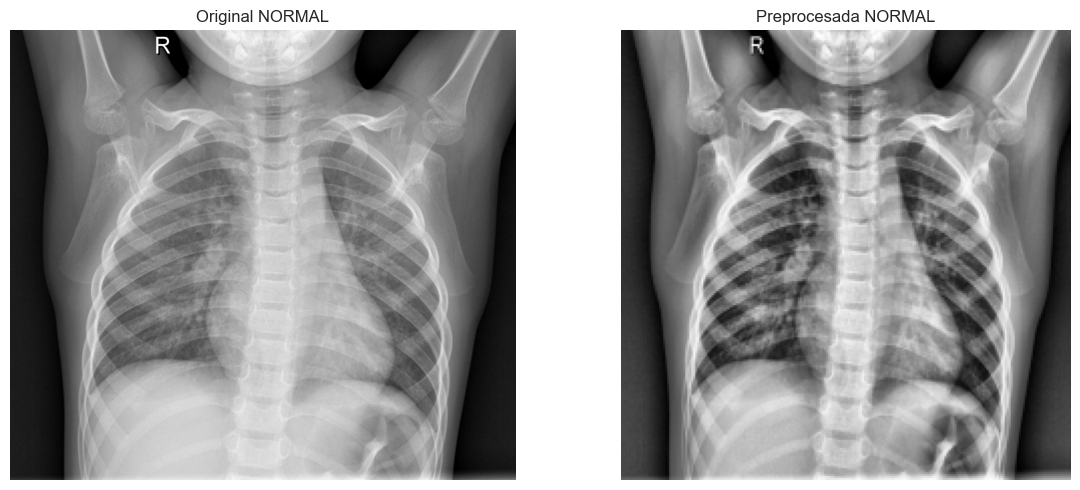

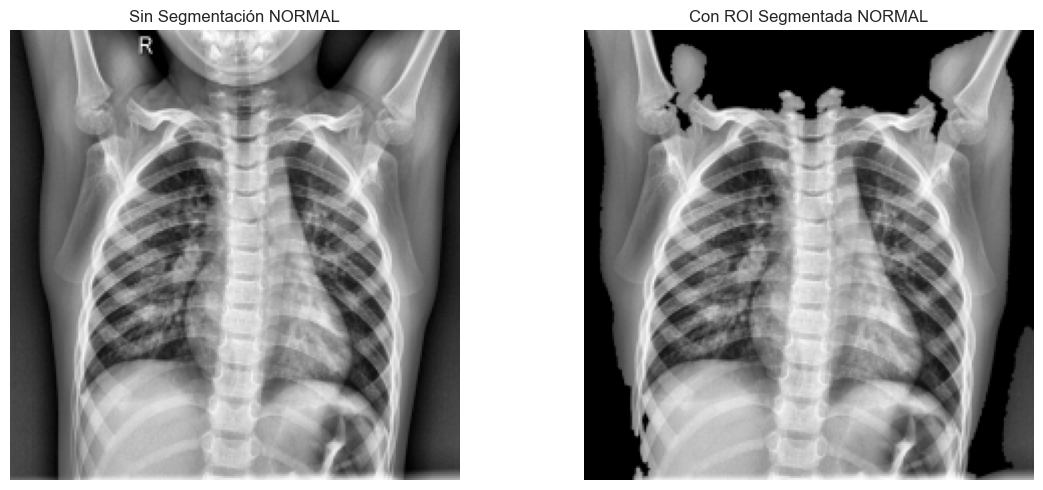

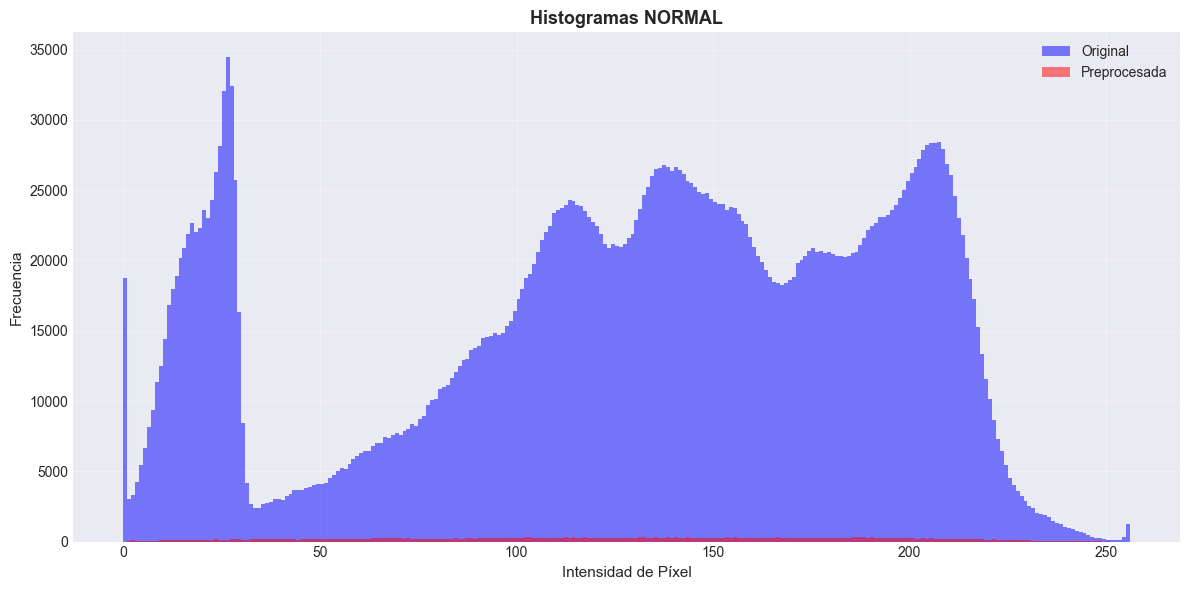

In [16]:
# Demostrar pipeline en imagen NORMAL
demonstrate_pipeline(example_normal, "NORMAL")


DEMOSTRANDO PIPELINE: PNEUMONIA


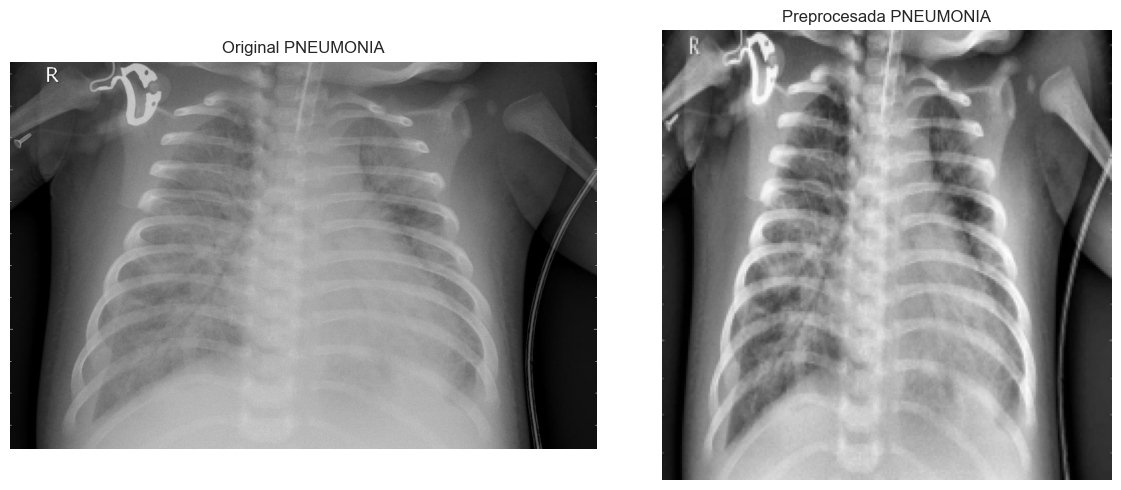

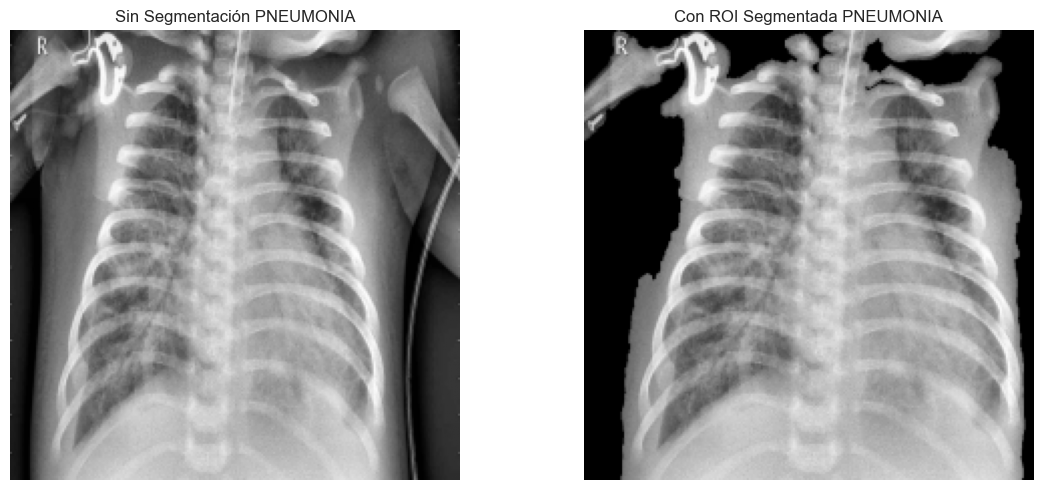

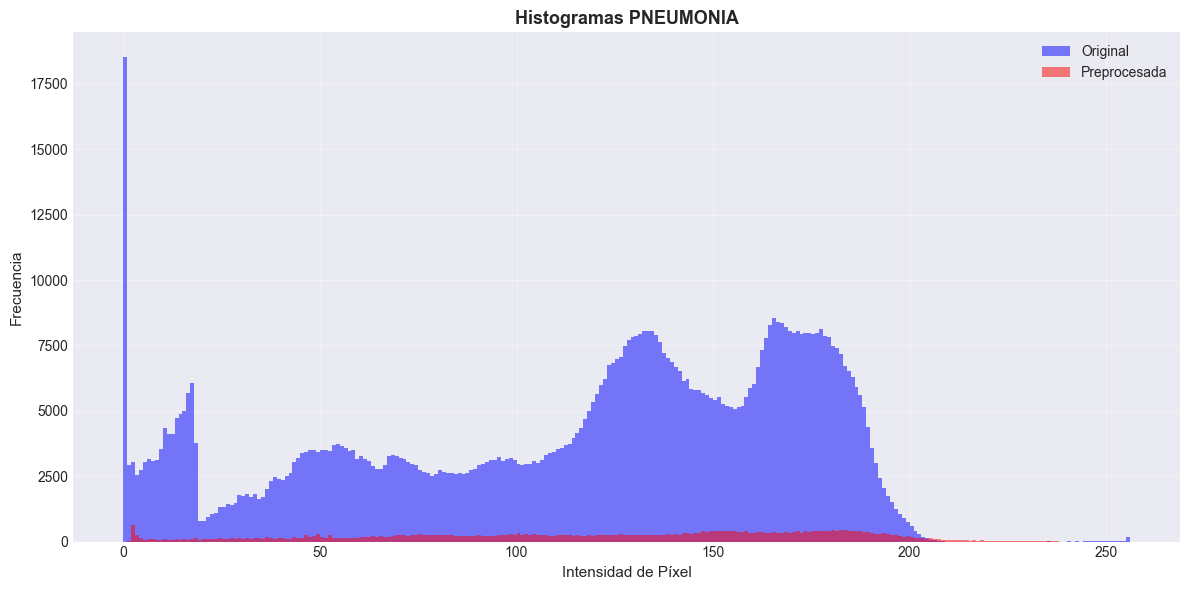

In [17]:
# Demostrar pipeline en imagen PNEUMONIA
demonstrate_pipeline(example_pneumonia, "PNEUMONIA")

## Comparación de Métodos de Mejora de Contraste

Se comparan CLAHE y ecualización global para ilustrar diferencias. CLAHE evita sobre-saturar regiones homogéneas y preserva mejor los detalles locales.

In [18]:
def compare_contrast_methods(image, label):
    """Compara diferentes métodos de mejora de contraste."""
    if image is None:
        print("Sin imagen para comparar.")
        return
    
    print(f"\n{'='*60}")
    print(f"COMPARACIÓN DE MÉTODOS DE CONTRASTE: {label}")
    print(f"{'='*60}")
    
    # Aplicar diferentes métodos
    clahe_img = apply_clahe(image)
    hist_eq_img = apply_histogram_equalization(image)
    
    # Comparaciones visuales
    plot_image_comparison(image, clahe_img, 
                         title1=f"Original {label}", 
                         title2=f"CLAHE {label}")
    
    plot_image_comparison(image, hist_eq_img, 
                         title1=f"Original {label}", 
                         title2=f"Ecualización Global {label}")
    
    plot_image_comparison(clahe_img, hist_eq_img, 
                         title1=f"CLAHE {label}", 
                         title2=f"Ecualización Global {label}")
    
    # Comparar histogramas
    plot_multiple_histograms([image, clahe_img, hist_eq_img], 
                            ["Original", "CLAHE", "Hist Eq Global"], 
                            title=f"Comparación de Histogramas {label}")

print("Función de comparación definida.")

Función de comparación definida.



COMPARACIÓN DE MÉTODOS DE CONTRASTE: NORMAL


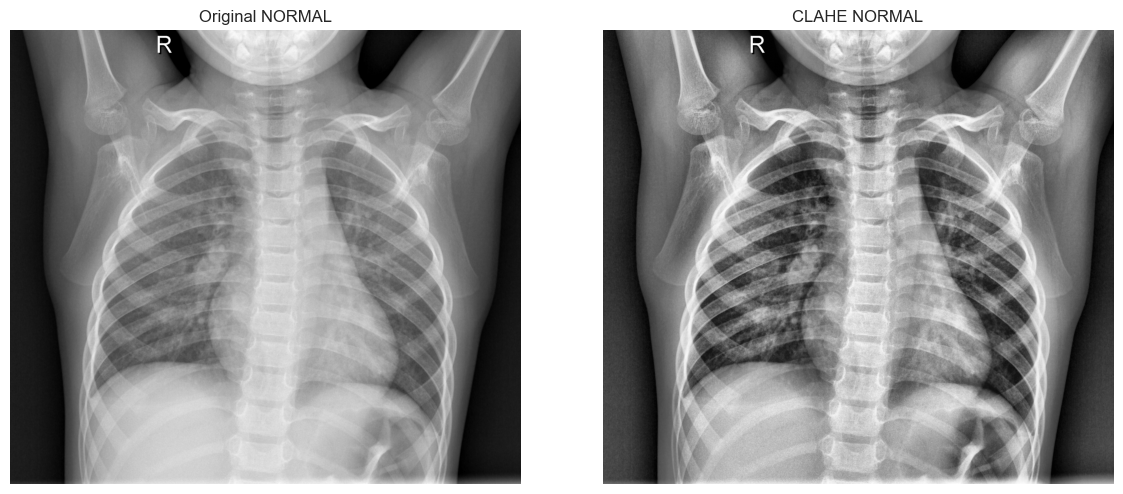

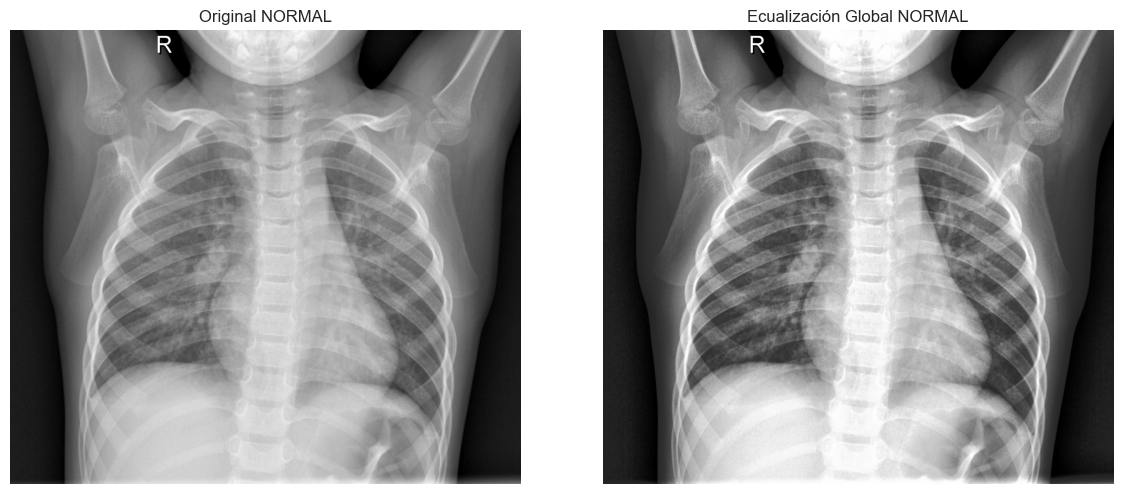

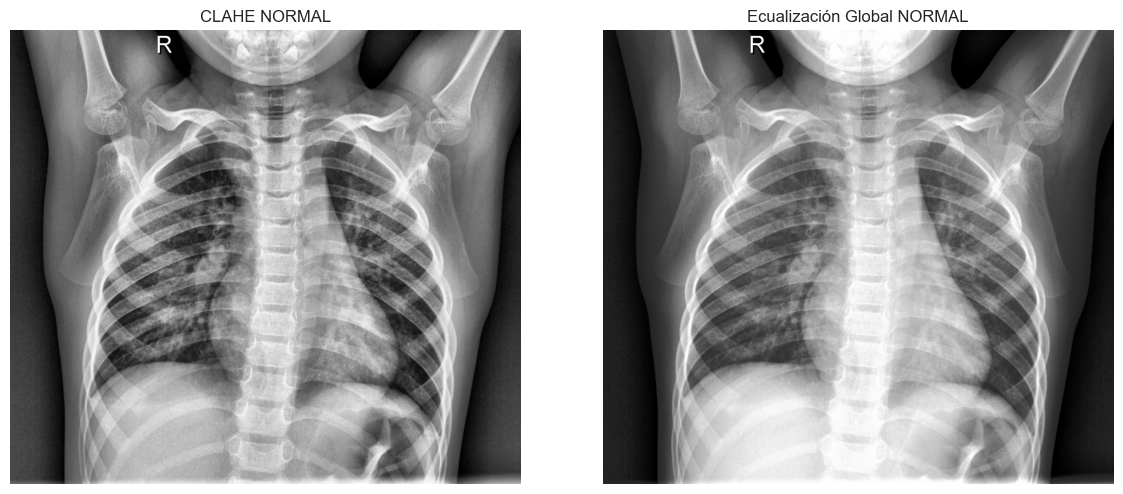

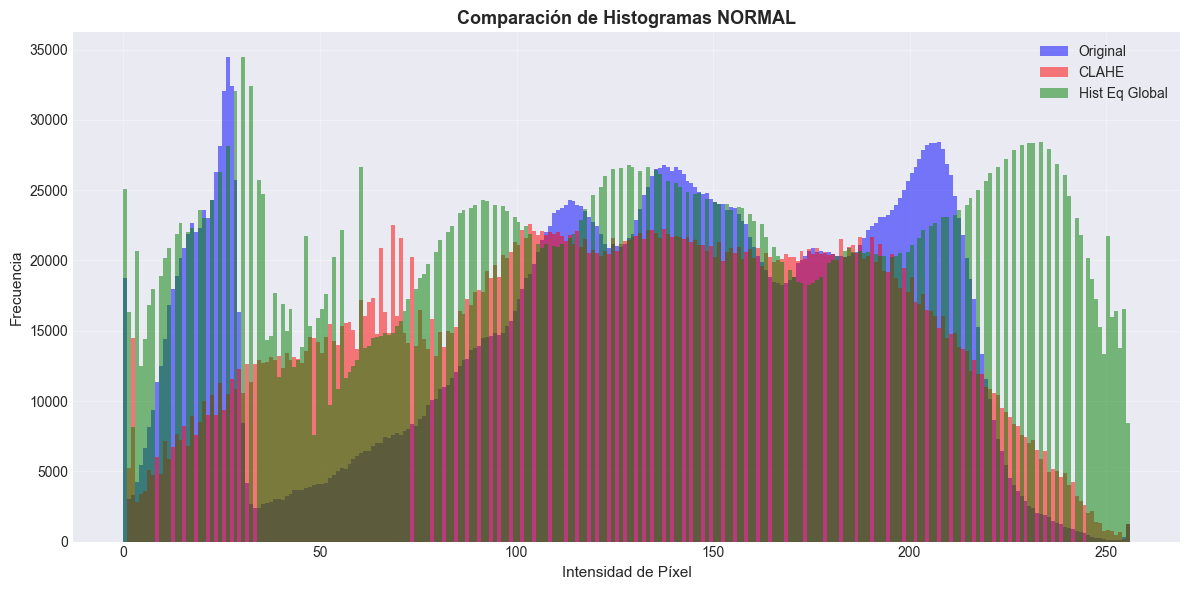

In [19]:
# Comparar métodos en imagen NORMAL
compare_contrast_methods(example_normal, "NORMAL")


COMPARACIÓN DE MÉTODOS DE CONTRASTE: PNEUMONIA


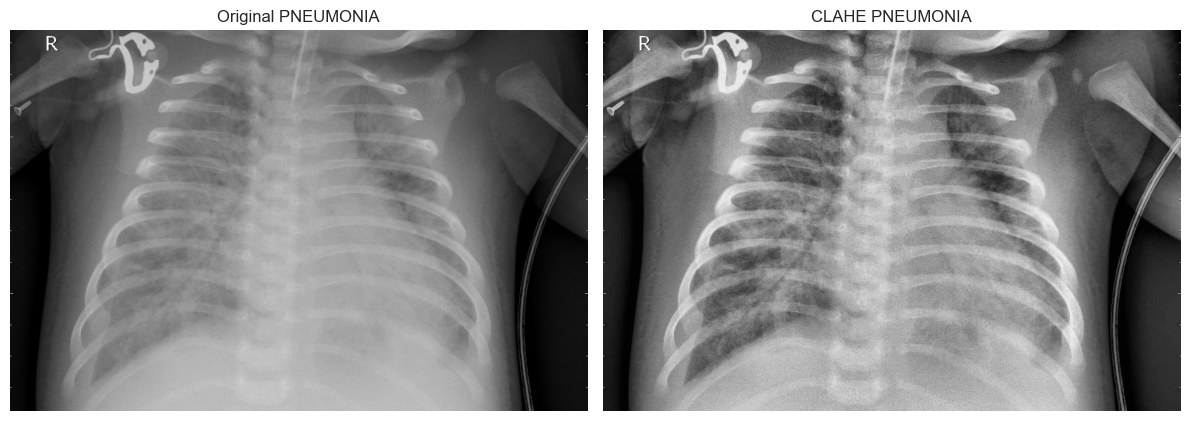

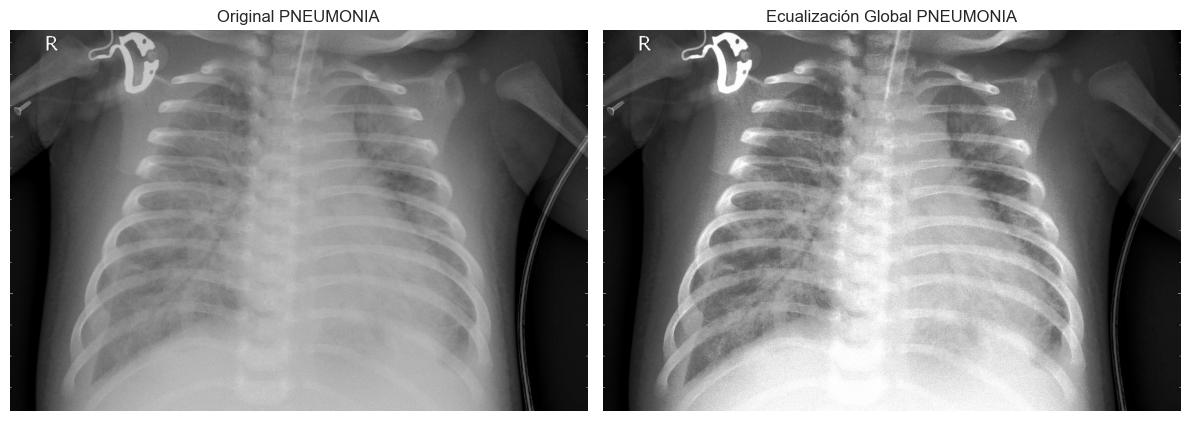

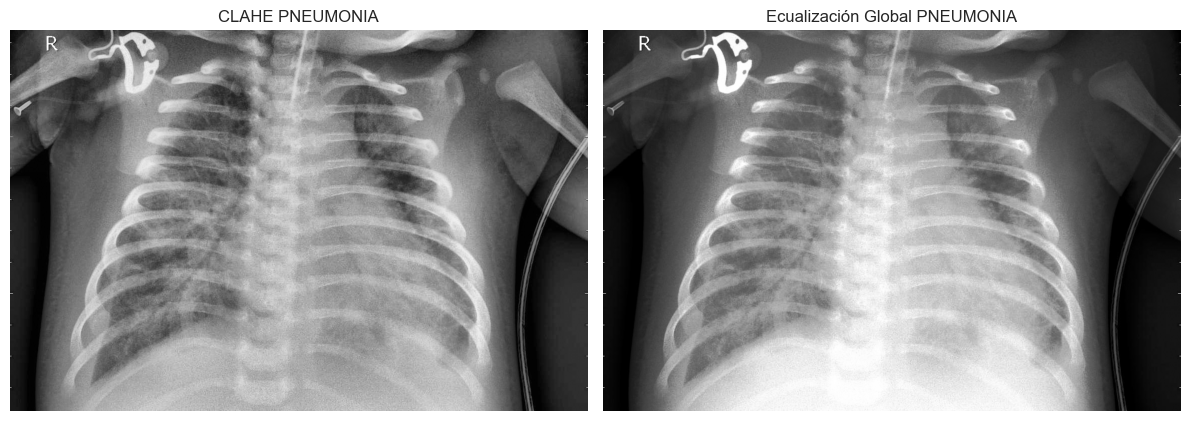

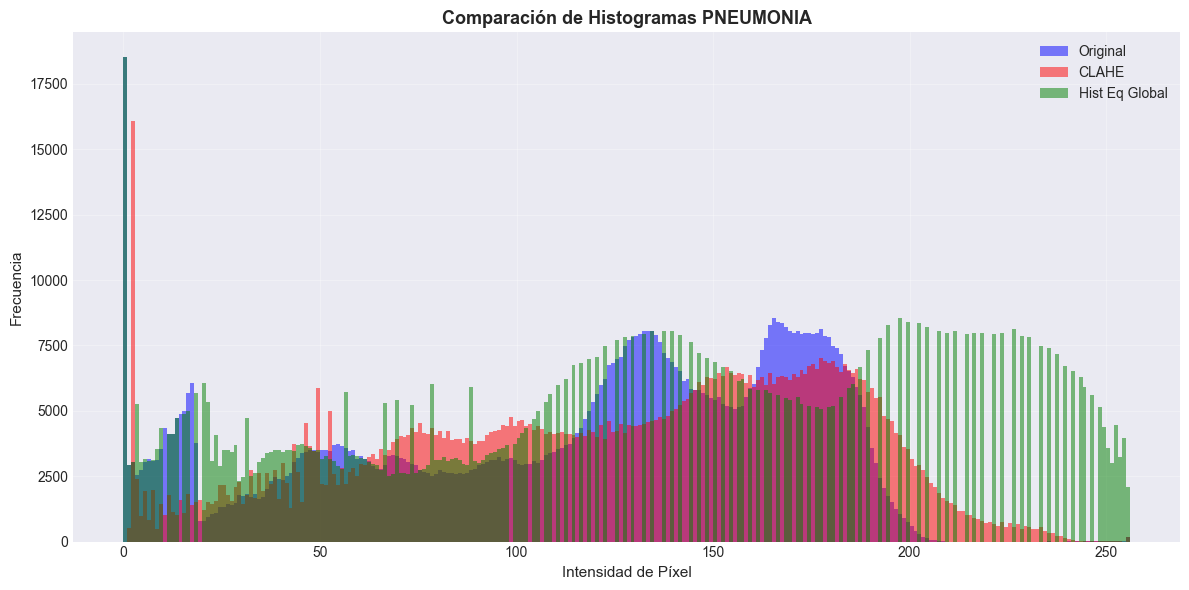

In [20]:
# Comparar métodos en imagen PNEUMONIA
compare_contrast_methods(example_pneumonia, "PNEUMONIA")

## Segmentación de Región Pulmonar

La segmentación busca aislar el área pulmonar y reducir el ruido de partes irrelevantes (huesos, borde de la placa). Se utiliza umbral adaptativo + operaciones morfológicas simples. Esta técnica puede refinarse con métodos más avanzados (U-Nets) en fases posteriores.

In [21]:
def demonstrate_segmentation(image, label):
    """Demuestra la segmentación de región pulmonar."""
    if image is None:
        print("No hay imagen para segmentación.")
        return
    
    print(f"\n{'='*60}")
    print(f"SEGMENTACIÓN DE REGIÓN PULMONAR: {label}")
    print(f"{'='*60}")
    
    # Segmentar región pulmonar
    mask, segmented = segment_lung_region(image)
    
    # Visualizar resultados
    plot_image_comparison(image, mask, 
                         title1=f"Original {label}", 
                         title2=f"Máscara Pulmonar {label}")
    
    plot_image_comparison(mask, segmented, 
                         title1=f"Máscara {label}", 
                         title2=f"Imagen Segmentada {label}")

print("Función de segmentación definida.")

Función de segmentación definida.



SEGMENTACIÓN DE REGIÓN PULMONAR: NORMAL


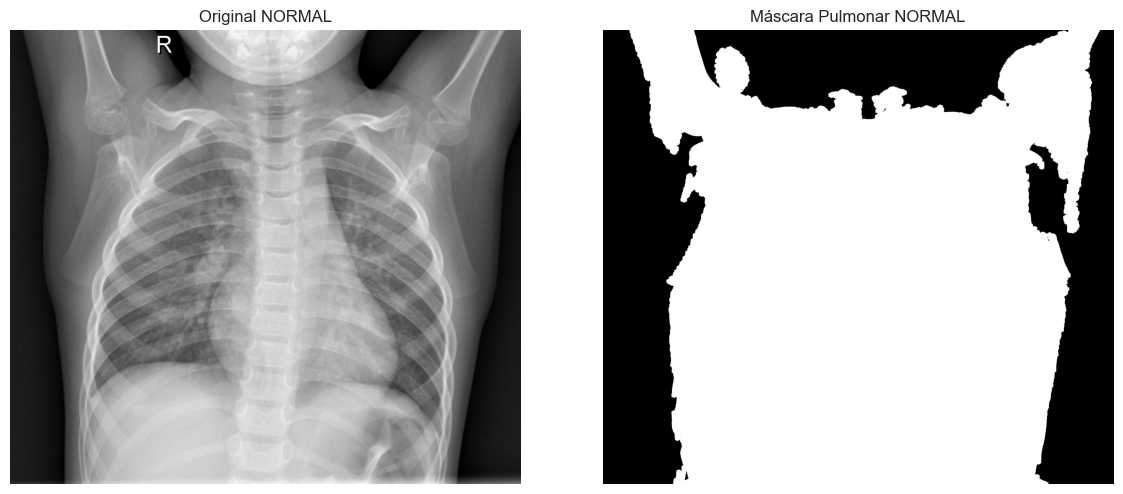

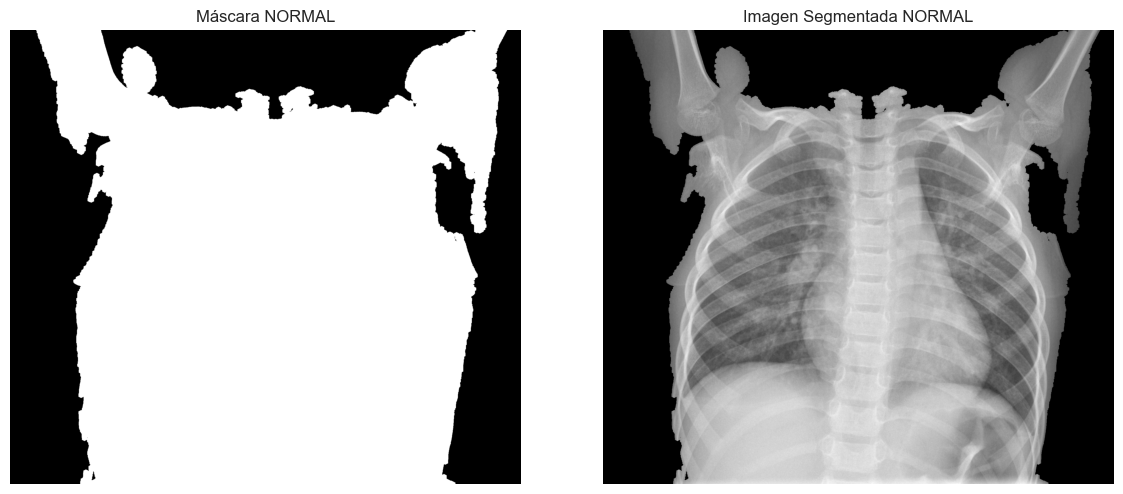

In [22]:
# Ejemplo segmentación NORMAL
demonstrate_segmentation(example_normal, "NORMAL")


SEGMENTACIÓN DE REGIÓN PULMONAR: PNEUMONIA


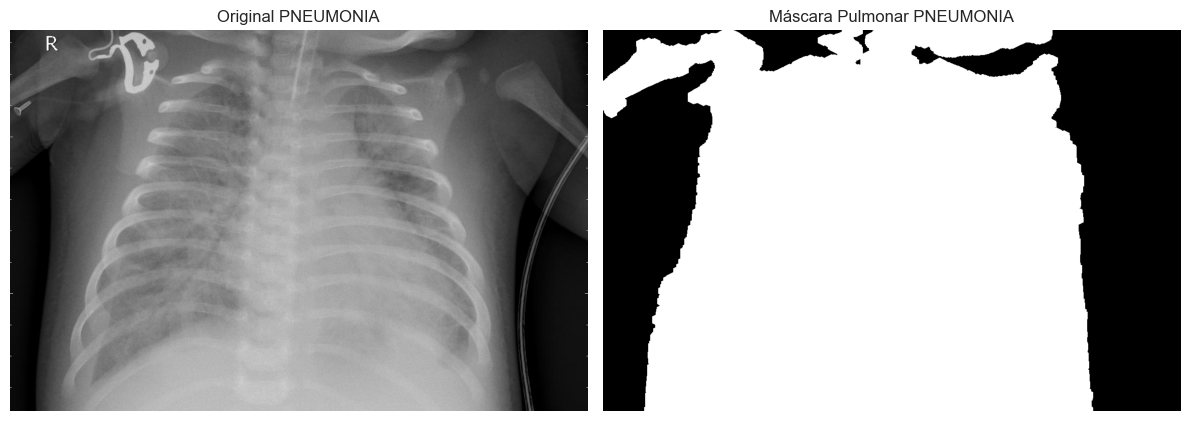

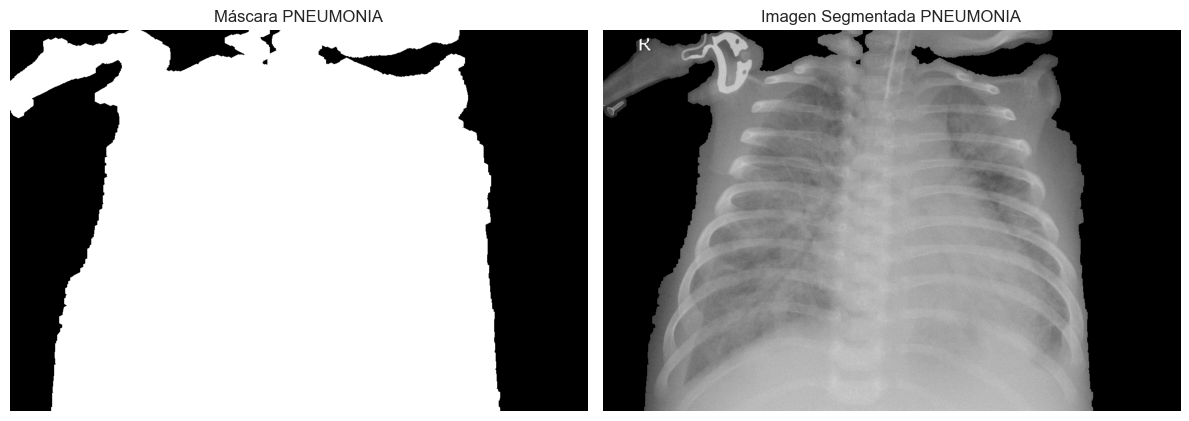

In [23]:
# Ejemplo segmentación PNEUMONIA
demonstrate_segmentation(example_pneumonia, "PNEUMONIA")

## Procesamiento en Lote (Ejemplo)

Para el dataset completo, se aplicaría el pipeline a cada imagen y se guardarían resultados en `data/processed/`. Aquí se ilustra con unas pocas muestras por razones de tiempo/memoria.

In [24]:
# Crear subset para prueba de procesamiento en lote
subset_all = []
if sample_normal_imgs: 
    subset_all.extend(sample_normal_imgs[:4])
if sample_pneumonia_imgs: 
    subset_all.extend(sample_pneumonia_imgs[:4])

print(f"Subset creado con {len(subset_all)} imágenes para demostración")

Subset creado con 8 imágenes para demostración


In [25]:
# Procesar subset
if subset_all:
    print("\n=== PROCESAMIENTO EN LOTE ===")
    processed_subset = preprocess_dataset(
        subset_all, 
        segment_roi=False, 
        apply_clahe_enhancement=True,
        verbose=True
    )
    print(f"\n✓ Total imágenes procesadas: {len(processed_subset)}")
    print(f"✓ Forma de cada imagen procesada: {processed_subset[0].shape}")
else:
    print("No hay imágenes para procesar en lote.")


=== PROCESAMIENTO EN LOTE ===
✓ Preprocesamiento completado: 8 imágenes

✓ Total imágenes procesadas: 8
✓ Forma de cada imagen procesada: (224, 224)



=== RESULTADO DEL PROCESAMIENTO EN LOTE ===


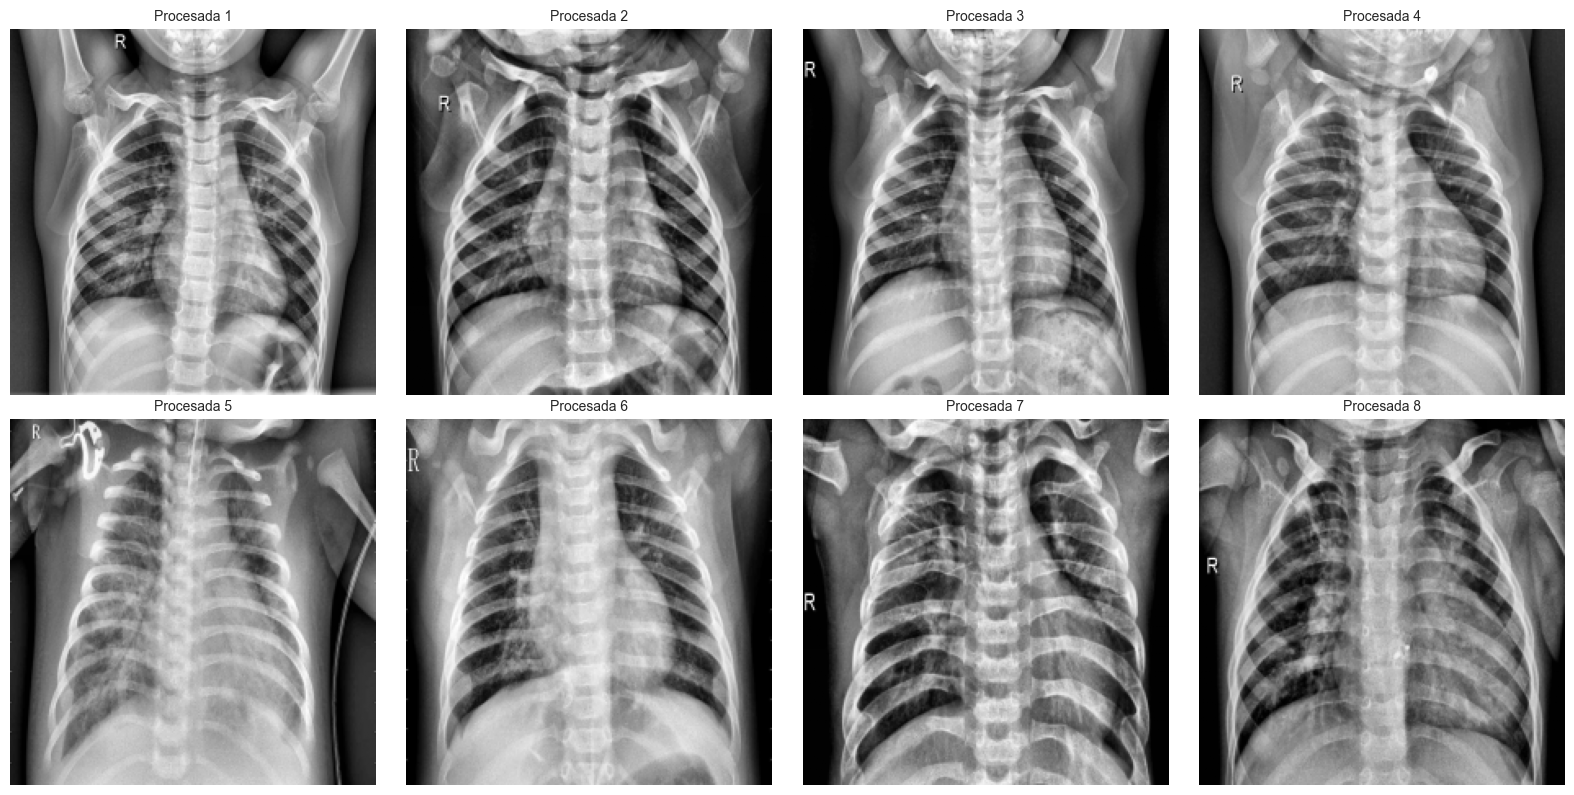

In [26]:
# Visualizar resultado del procesamiento en lote
if 'processed_subset' in locals() and processed_subset:
    print("\n=== RESULTADO DEL PROCESAMIENTO EN LOTE ===")
    plot_image_grid(
        processed_subset, 
        titles=[f"Procesada {i+1}" for i in range(len(processed_subset))],
        rows=2, 
        cols=4, 
        figsize=(16, 8)
    )

## Estadísticas de Intensidad

Análisis comparativo de las intensidades de píxeles antes y después del preprocesamiento.

In [27]:
# Estadísticas de intensidad
if example_normal is not None:
    from utils import get_image_statistics
    
    print("\n=== ESTADÍSTICAS DE INTENSIDAD ===")
    
    # Original
    stats_orig = get_image_statistics(example_normal)
    print("\nOriginal NORMAL:")
    for key, value in stats_orig.items():
        print(f"  {key}: {value:.2f}")
    
    # Procesada
    processed_example = preprocess_xray(example_normal, segment_roi=False)
    stats_proc = get_image_statistics(processed_example)
    print("\nPreprocesada NORMAL:")
    for key, value in stats_proc.items():
        print(f"  {key}: {value:.2f}")


=== ESTADÍSTICAS DE INTENSIDAD ===

Original NORMAL:
  mean: 128.91
  std: 62.30
  min: 0.00
  max: 255.00
  median: 137.00

Preprocesada NORMAL:
  mean: 126.30
  std: 58.79
  min: 1.00
  max: 253.00
  median: 129.00


## Resultados y Observaciones

### Hallazgos Principales:

1. **Distribución de Clases**: El dataset muestra un desbalance significativo, con más casos de neumonía que casos normales. Esto requerirá estrategias de balanceo en el entrenamiento.

2. **Variabilidad de Tamaños**: Las imágenes tienen dimensiones heterogéneas, justificando completamente la normalización a un tamaño estándar (224x224).

3. **Efectividad de CLAHE**: 
   - Mejora el contraste local sin destruir información
   - Preserva mejor los detalles finos que la ecualización global
   - Evita la sobre-saturación en regiones homogéneas
   - Hace más evidentes los patrones de infiltración pulmonar

4. **Segmentación ROI**: 
   - La segmentación morfológica simple funciona en casos con fondo homogéneo
   - Puede fallar en imágenes con mucho ruido o artefactos
   - Es recomendable como paso opcional, no obligatorio
   - Métodos más avanzados (redes U-Net) serían más robustos

5. **Pipeline Modular**: La estructura modular facilita la experimentación con diferentes configuraciones del preprocesamiento.

### Diferencias Observadas entre Clases:

- **Imágenes NORMALES**: Campos pulmonares más claros y uniformes, estructuras vasculares bien definidas
- **Imágenes PNEUMONIA**: Opacidades, infiltrados, áreas de consolidación, contraste reducido en regiones afectadas

## Referencias

1. **Dataset**:
   - Kermany, D. S., Goldbaum, M., Cai, W., et al. (2018). "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning." *Cell*, 172(5), 1122-1131.
   - Dataset: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) - Kaggle

2. **Técnicas de Preprocesamiento**:
   - Pizer, S. M., et al. (1987). "Adaptive Histogram Equalization and Its Variations." *Computer Vision, Graphics, and Image Processing*, 39(3), 355-368.
   - Zuiderveld, K. (1994). "Contrast Limited Adaptive Histogram Equalization." *Graphics Gems IV*, 474-485.

3. **Procesamiento de Imágenes Médicas**:
   - Gonzalez, R. C., & Woods, R. E. (2018). *Digital Image Processing* (4th ed.). Pearson.
   - Szeliski, R. (2022). *Computer Vision: Algorithms and Applications* (2nd ed.). Springer.

4. **Documentación Técnica**:
   - OpenCV Documentation: https://docs.opencv.org/
   - scikit-image Documentation: https://scikit-image.org/
   - NumPy Documentation: https://numpy.org/doc/

---

**Autor**: David A. Londoño  
**Curso**: Visión por Computador  
**Trabajo**: #3 - Clasificación de Imágenes Médicas PARTE 1
**Fecha**: Noviembre 2025